# Stage 3: Generate Beta Factors

- Use Risk Model
- Compute Daily Betas for 1 year

In [1]:
from platform import python_version
import time
from datetime import datetime
import os
import pandas as pd
import numpy as np
import math
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pickle

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (20, 8)

# Set the import path for the tools directiory
import sys
# insert at position 1 in the path, as 0 is the path of this file.
sys.path.insert(1, '../tools')
import importlib
import ameritrade_functions as amc
importlib.reload(amc)
import utils
importlib.reload(utils)
import trading_factors as alpha_factors
importlib.reload(alpha_factors)

print(f'Python version : {python_version()}')
print(f'Pandas version : {pd.__version__}')

Python version : 3.8.10
Pandas version : 0.25.3


## Configure Ameritrade Information

Ameritrade credentials are stored in environment variables to keep from having unencrypted passwords stored on disk.

The module automatically masks the account numbers to protect the actual accounts. An Ameritrade user can have many investment accounts. We will be working with only one for this demonstration.

In [2]:
username = os.getenv('maiotradeuser')
password = os.getenv('maiotradepw')
client_id = os.getenv('maiotradeclientid')

masked_account_number = '#---9216'
account_portfolios_file_name = 'data/portfolio_data.csv'
portfolio_file_name = 'data/portfolio_' + masked_account_number[-4:] + '.csv'
price_histories_file_name = 'data/price_histories.csv'

# Price History data from Stage 1

In [3]:
price_histories = utils.read_price_histories(price_histories_file_name)
print(f'Date range for price histories: {price_histories.date.min().date()} to {price_histories.date.max().date()}')
pricing = utils.get_close_values(price_histories)
print(f'You have {len(pricing.columns)} stocks')
print(pricing.columns.to_list())
pricing.tail()

Date range for price histories: 2016-10-04 to 2021-10-04
You have 437 stocks
['A', 'AAL', 'AAP', 'AAPL', 'ABBV', 'ABC', 'ABT', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AES', 'AFL', 'AIG', 'AJG', 'AKAM', 'ALB', 'ALGN', 'ALK', 'ALL', 'ALLE', 'AMAT', 'AMCR', 'AMD', 'AMGN', 'AMP', 'AMT', 'AMZN', 'ANET', 'ANSS', 'ANTM', 'AON', 'APA', 'APD', 'APH', 'ARE', 'ATO', 'ATVI', 'AVB', 'AVGO', 'AVY', 'AWK', 'AXP', 'AZO', 'BA', 'BAC', 'BAX', 'BBY', 'BDX', 'BEN', 'BIIB', 'BIO', 'BK', 'BKNG', 'BKR', 'BLL', 'BMY', 'BR', 'BRO', 'BSX', 'BWA', 'C', 'CAH', 'CARR', 'CAT', 'CB', 'CBRE', 'CCL', 'CDAY', 'CDNS', 'CDW', 'CE', 'CERN', 'CF', 'CFG', 'CHD', 'CHTR', 'CI', 'CINF', 'CL', 'CLX', 'CMA', 'CMCSA', 'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COO', 'COP', 'COST', 'CPB', 'CPRT', 'CRL', 'CRM', 'CSCO', 'CSX', 'CTAS', 'CTLT', 'CTSH', 'CTVA', 'CTXS', 'CVS', 'CVX', 'CZR', 'D', 'DAL', 'DD', 'DE', 'DFS', 'DG', 'DHI', 'DHR', 'DIS', 'DISCA', 'DISCK', 'DISH', 'DLR', 'DLTR', 'DOV', 'DOW', 'DRE', 'DRI', 'D

ticker,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2021-09-28 00:00:00+00:00,159.900,21.43,214.78,141.91,107.340,121.290,118.74,324.21,578.7700,171.29,...,84.3100,61.42,59.92,59.14,128.920,122.54,150.85,531.18,62.74,192.77
2021-09-29 00:00:00+00:00,160.000,21.01,216.77,142.83,108.840,122.500,119.46,323.53,577.7000,168.84,...,83.6300,62.67,59.88,58.43,127.780,123.04,149.36,525.67,63.74,194.99
2021-09-30 00:00:00+00:00,157.530,20.52,208.89,141.50,107.870,119.450,118.13,319.92,575.7200,167.48,...,84.7500,62.50,58.82,58.05,123.680,122.31,146.36,515.42,61.89,194.14
2021-10-01 00:00:00+00:00,155.990,21.65,208.00,142.65,109.090,119.810,117.21,324.86,577.4700,167.37,...,87.2100,62.49,60.93,59.07,121.300,123.64,149.47,510.98,63.65,196.19
2021-10-04 00:00:00+00:00,155.405,21.78,208.05,140.95,109.601,120.185,117.14,322.99,571.0875,166.94,...,86.9487,62.90,61.72,59.41,121.445,124.06,149.35,508.08,64.04,193.98


In [4]:
returns = alpha_factors.FactorReturns(price_histories).factor_data
returns.head()

ticker,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACN,ADBE,ADI,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2016-10-05 00:00:00+00:00,0.006810,0.006358,0.016178,0.000442,0.006171,-0.006228,0.015088,-0.000254,0.003776,0.006826,...,0.016056,-0.002023,0.008658,0.000679,-0.005950,-0.018558,0.010163,0.008464,0.013287,-0.002488
2016-10-06 00:00:00+00:00,0.003176,0.007891,-0.001478,0.007403,-0.008873,0.001374,0.005367,0.002619,-0.002208,0.000927,...,-0.002044,0.002780,0.000460,0.002372,-0.002313,-0.013405,0.001837,-0.013520,-0.004409,-0.010209
2016-10-07 00:00:00+00:00,0.001690,-0.011594,-0.003908,0.001492,0.001590,-0.009403,0.000000,-0.021492,0.000737,-0.004955,...,-0.007497,-0.000252,-0.003453,0.009937,-0.020860,0.003197,0.001604,-0.004935,0.001577,0.003865
2016-10-10 00:00:00+00:00,0.006522,0.030282,-0.000473,0.017297,0.006020,0.003144,0.012259,0.012508,0.005508,-0.016749,...,0.016967,0.007044,0.019409,0.002009,-0.007514,-0.003769,0.013195,-0.000582,0.002518,0.016071
2016-10-11 00:00:00+00:00,-0.042842,-0.017902,-0.008819,0.002152,-0.014638,-0.000377,-0.055294,-0.004180,-0.017266,-0.019929,...,-0.009879,-0.011092,-0.007946,-0.032294,-0.013589,0.009793,-0.047202,-0.027605,-0.016163,-0.033385


## Generate Daily Betas using 1 year of returns and PCA

Start with the last date, subtract 1 year to get the start and end dates for the betas.

For each date, use 1 year of returns up to that date to generate a beta for that date.

In [5]:
end_date = returns.index.max()
start_date = end_date - pd.offsets.DateOffset(years=1)
print(f'Generating 1 year Betas from {start_date} to {end_date}')
beta_dates = pd.date_range(start_date, end_date, freq='D')
daily_betas = {}
for beta_date in returns[start_date:].index:
    start_of_returns = beta_date - pd.offsets.DateOffset(years=1) + pd.offsets.DateOffset(days=1) 
    beta_returns = returns.loc[start_of_returns:beta_date]
    risk_model = alpha_factors.RiskModelPCA(beta_returns, 1, 20)
    daily_betas[beta_date.strftime('%m/%d/%Y')] = risk_model

Generating 1 year Betas from 2020-10-04 00:00:00+00:00 to 2021-10-04 00:00:00+00:00


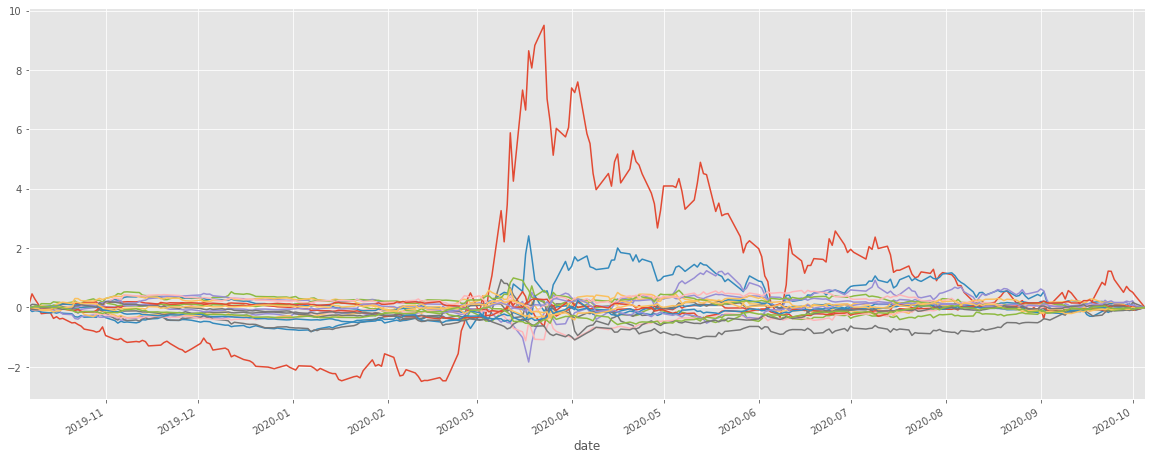

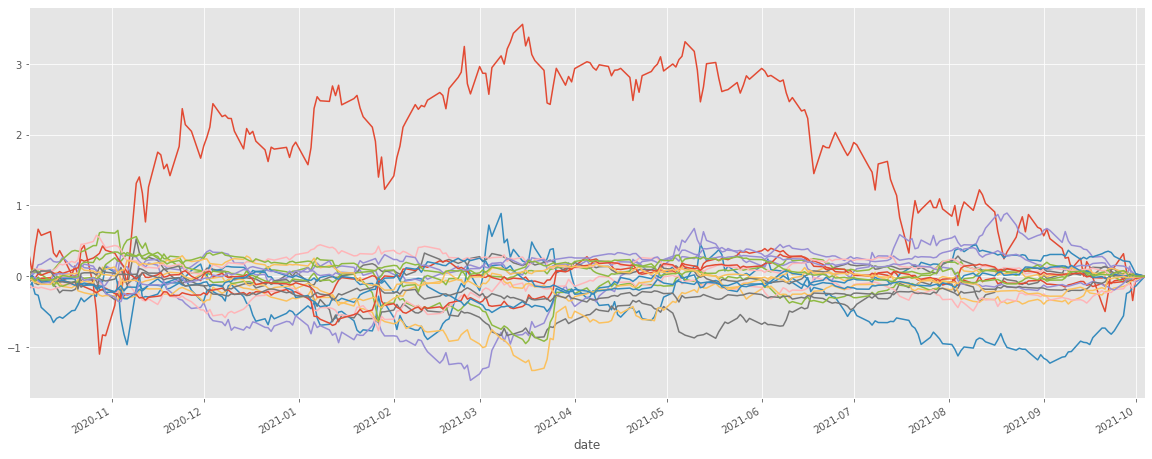

In [6]:
daily_betas[list(daily_betas.keys())[0]].factor_returns_.cumsum().plot(legend=None)
daily_betas[list(daily_betas.keys())[-1]].factor_returns_.cumsum().plot(legend=None)

In [7]:
with open('data/daily_beta.pickle', 'wb') as f:
    # Pickle the 'data' dictionary using the highest protocol available.
    pickle.dump(daily_betas, f, pickle.HIGHEST_PROTOCOL)

In [8]:
with open('data/daily_beta.pickle', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    daily_betas = pickle.load(f)

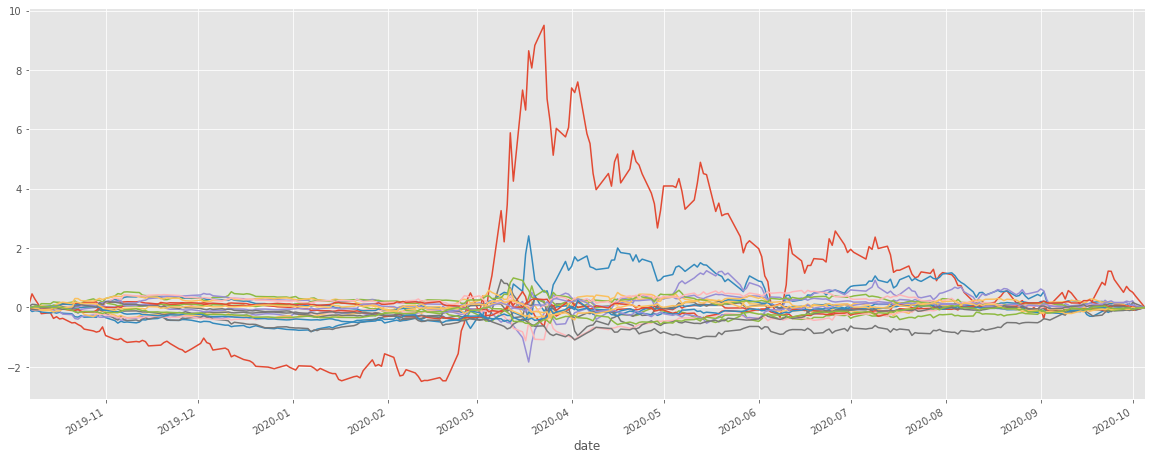

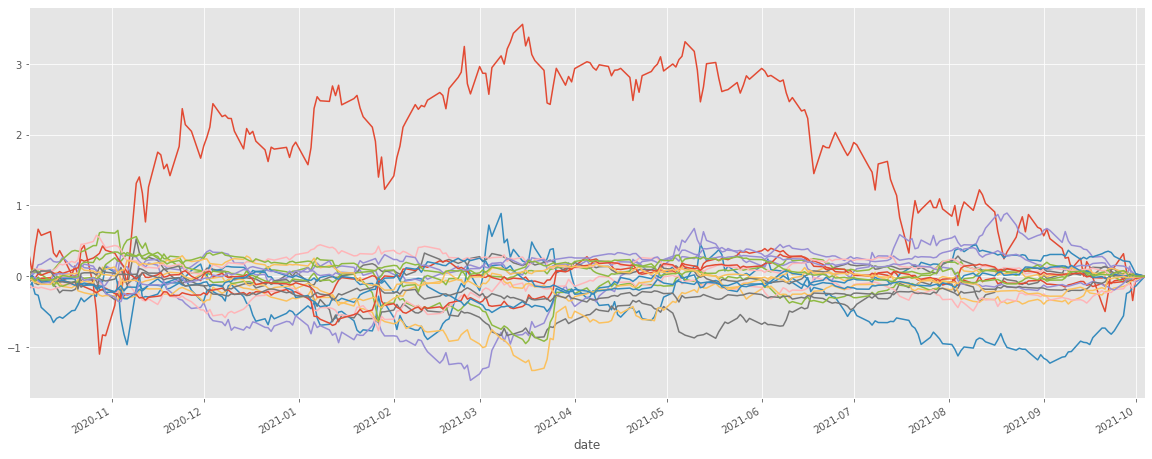

In [9]:
daily_betas[list(daily_betas.keys())[0]].factor_returns_.cumsum().plot(legend=None)
daily_betas[list(daily_betas.keys())[-1]].factor_returns_.cumsum().plot(legend=None)